# Lipstick Product Data Processing and Analysis

This notebook processes lipstick product data from multiple sources including:
- Product reviews and metadata from JSON files
- Product images (cover and lipstick images)
- Color information extraction

## Setup and Import Libraries

In [20]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import base64
import zipfile
import os
import re
from IPython.display import display, HTML

# Set visualization and display options
sns.set_theme(style="ticks")
# pd.options.display.max_rows = 200
# pd.options.display.max_columns = 999
# plt.rcParams["figure.figsize"] = (20,5)

## 1. Load and Process Review Data
First, we'll define functions to extract review and product data from JSON files.

In [3]:
def extract_reviews(product_id, source_data):
    """Extract review data for a given product"""
    review_fields = [
        'Id', 'ProductId', 'Rating', 'Title', 'ReviewText', 'Helpfulness',
        'IsRecommended', 'SubmissionTime',
        'ContextDataValues.skinType.ValueLabel',
        'ContextDataValues.eyeColor.ValueLabel',
        'ContextDataValues.hairColor.ValueLabel',
        'ContextDataValues.skinTone.ValueLabel',
        'ContextDataValues.age.ValueLabel',
        'ContextDataDistribution.skinConcerns.ValueLabel'
    ]
    
    df = pd.json_normalize(source_data[product_id][1])
    for field in review_fields:
        if field not in df:
            df[field] = np.nan
            
    df_reviews = df.loc[:, review_fields].copy()
    df_reviews['product_id'] = product_id
    df_reviews['sku_id'] = df_reviews['ProductId']
    df_reviews.rename(columns={'Id': 'review_id'}, inplace=True)
    
    return df_reviews

def extract_product_info(product_id, source_data):
    """Extract product metadata for a given product"""
    metadata_fields = [
        'AverageOverallRating', 'FirstSubmissionTime',
        'RecommendedCount', 'NotRecommendedCount', 'RatingDistribution',
        'ContextDataDistribution.age.Values',
        'ContextDataDistribution.skinType.Values',
        'ContextDataDistribution.skinConcerns.Values',
        'ContextDataDistribution.skinTone.Values',
        'ContextDataDistribution.eyeColor.Values',
        'ContextDataDistribution.hairColor.Values'
    ]
    
    df = pd.DataFrame(source_data[product_id][0])
    df = df.transpose().reset_index()
    df['sku_id'] = df['Id']
    df['product_id'] = product_id
    
    base_columns = ['product_id', 'sku_id', 'Name', 'Brand', 
                    'BrandExternalId', 'CategoryId', 'TotalReviewCount']
    product_base = df.loc[:, base_columns].copy()
    
    stats = pd.json_normalize(df['ReviewStatistics'])
    for field in metadata_fields:
        if field not in stats:
            stats[field] = np.nan
            
    return pd.concat([product_base, stats[metadata_fields]], axis=1)

### Process Review Files

In [4]:
# Load and process review files
products_list = []
reviews_list = []

for file_num in tqdm(range(1, 15), desc="Processing review files"):
    file_path = f'raw_corpus/feedback/sephora_reviews_2024_{file_num}.json'
    try:
        with open(file_path, 'rb') as f:
            data = json.load(f)
            
        for product_id, product_data in data.items():
            if product_data != [[], []] and product_data != [None, None]:
                products_list.append(extract_product_info(product_id, data))
                reviews_list.append(extract_reviews(product_id, data))
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Combine all data
df_products = pd.concat(products_list, ignore_index=True)
df_reviews = pd.concat(reviews_list, ignore_index=True)

print(f"Total products: {len(df_products)}")
print(f"Total reviews: {len(df_reviews)}")

Processing review files:   0%|          | 0/14 [00:00<?, ?it/s]

An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_1.json'


Processing review files: 100%|██████████| 14/14 [00:02<00:00,  6.02it/s]

An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_3.json'
An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_4.json'
An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_5.json'
An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_6.json'
An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_7.json'
An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_8.json'
An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_9.json'
An unexpected error occurred: [Errno 2] No such file or directory: 'raw_corpus/feedback/sephora_reviews_2024_10.json'
An unexpected error occurred: [Errno 2] No such file or directo

## 2. Process Product List and Details

In [5]:
# Load product list
with open("raw_corpus/metadata/product_list.pkl", 'rb') as f:
    df_product_list = pickle.load(f)

df_product_list.rename(columns={'productId': 'product_id'}, inplace=True)

# Load product details
with open("raw_corpus/metadata/product_detail.pkl", 'rb') as f:
    product_details_dict = pickle.load(f)

df_product_details = pd.json_normalize(product_details_dict, max_level=0)

# Process color mappings
color_mappings = df_product_details['sku_color_mapping'].apply(lambda x: list(x.items()))
color_mappings = color_mappings.explode()
df_color_info = pd.DataFrame(color_mappings.tolist(), columns=['sku_id', 'color_description'])
df_color_info = df_color_info.dropna()
df_color_info['sku_id'] = df_color_info['sku_id'].astype(str)

print(f"Products in category list: {len(df_product_list)}")
print(f"Color mappings available: {len(df_color_info)}")

Products in category list: 323
Color mappings available: 1255


## 3. Process Images and Extract Colors

In [6]:
def extract_rgb_from_image(image):
    """Extract average RGB values from image, excluding white and transparent pixels"""
    image = image.convert('RGBA')
    img_array = np.array(image)
    
    rgb = img_array[:, :, :3]
    alpha = img_array[:, :, 3]
    
    # Create masks
    non_white = np.all(rgb < 240, axis=-1)
    non_transparent = alpha > 0
    valid_pixels = non_white & non_transparent
    
    filtered_rgb = rgb[valid_pixels]
    
    if len(filtered_rgb) > 0:
        return filtered_rgb.mean(axis=0).astype(int)
    return np.array([0, 0, 0])

def process_image(base64_string):
    """Process base64 encoded image and extract RGB values"""
    try:
        image_data = base64.b64decode(base64_string)
        image = Image.open(BytesIO(image_data))
        return extract_rgb_from_image(image)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Initialize image columns
df_products['cover_image_base64'] = ''
df_products['lipstick_image_base64'] = ''

# Process images from zip files
image_files = [
    "raw_corpus/assets/product_cover_image.zip",
    "raw_corpus/assets/SKU_lipstick_color_image.zip"
]

for zip_path in image_files:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        extract_path = zip_path.replace('.zip', '')
        zip_ref.extractall(extract_path)
        
        for sku_id in tqdm(df_products['sku_id'].unique(), desc=f"Processing {os.path.basename(zip_path)}"):
            for root, _, files in os.walk(extract_path):
                for file in files:
                    if f's{sku_id}' in file:
                        img_path = os.path.join(root, file)
                        with open(img_path, 'rb') as img_file:
                            base64_data = base64.b64encode(img_file.read()).decode('utf-8')
                            
                        if 'lipstick' in zip_path:
                            df_products.loc[df_products['sku_id'] == sku_id, 'lipstick_image_base64'] = base64_data
                        else:
                            df_products.loc[df_products['sku_id'] == sku_id, 'cover_image_base64'] = base64_data

# Extract RGB values
df_products['avg_rgb'] = df_products['lipstick_image_base64'].apply(process_image)

# Keep only products with valid RGB values
df_products_with_images = df_products[df_products['avg_rgb'].notna()].copy()

print(f"Products with valid RGB values: {len(df_products_with_images)}")

Processing SKU_lipstick_color_image.zip: 100%|██████████| 392/392 [00:00<00:00, 949.44it/s]

Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f9430dbfef0>
Error proc

## 4. Create Final Dataset

In [7]:
# Create final merged dataset
df_final = df_reviews.merge(
    df_products_with_images,
    on=['sku_id', 'product_id'],
    how='inner'
).merge(
    df_color_info,
    on='sku_id',
    how='left'
).merge(
    df_product_list,
    on='product_id',
    how='left'
)

# Save processed datasets
df_products_with_images.to_pickle('metadata_with_assets.pkl')
df_reviews.to_pickle('metadata_with_feedback.pkl')
df_final.to_pickle('metadata_with_assets_feedback.pkl')

print("Dataset Statistics:")
print(f"Total products: {df_final['product_id'].nunique()}")
print(f"Total SKUs: {df_final['sku_id'].nunique()}")
print(f"Total reviews: {len(df_final)}")
# print(f"Average reviews per SKU: {len(df_final) / df_final['sku_id'].nunique():.2f}")

Dataset Statistics:
Total products: 0
Total SKUs: 0
Total reviews: 0


In [8]:
df_products_with_images = pd.read_pickle('processed_data/metadata_with_assets.pkl')
df_reviews = pd.read_pickle('processed_data/metadata_with_feedback.pkl')
df_final = pd.read_pickle('processed_data/metadata_with_assets_feedback.pkl')

## 5. Data Validation and Analysis

Let's examine our processed data to ensure quality and generate some insights.

In [9]:
# Check data completeness
def perform_statistical_analysis(df, entity_name):
    """Comprehensive statistical analysis of dataset attributes"""
    print(f"\n{entity_name} Statistical Analysis:")
    print("="* 60)
    
    # Core metrics
    print(f"Dimensions: {df.shape}")
    print(f"Memory Footprint: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Data completeness analysis
    null_metrics = df.isnull().sum()
    completeness_metrics = (null_metrics / len(df) * 100).round(2)
    data_quality_metrics = pd.DataFrame({
        'Missing_Count': null_metrics,
        'Missing_Percentage': completeness_metrics
    })
    print("\nData Completeness Metrics:")
    display(data_quality_metrics[data_quality_metrics['Missing_Count'] > 0])
    
    # Distribution analysis
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        print("\nNumerical Feature Distribution:")
        display(df[numeric_columns].describe())

# Analyze each dataset
perform_statistical_analysis(df_products_with_images, "Products Dataset")
perform_statistical_analysis(df_reviews, "Reviews Dataset")
perform_statistical_analysis(df_final, "Final Merged Dataset")


Products Dataset Statistical Analysis:
Dimensions: (1132, 22)
Memory Footprint: 0.20 MB

Data Completeness Metrics:


,Missing_Count,Missing_Percentage
ContextDataDistribution.age.Values,28,2.47
ContextDataDistribution.skinType.Values,1,0.09
ContextDataDistribution.skinConcerns.Values,1132,100.00
ContextDataDistribution.skinTone.Values,1,0.09
ContextDataDistribution.eyeColor.Values,1,0.09
ContextDataDistribution.hairColor.Values,1,0.09



Numerical Feature Distribution:


,AverageOverallRating,RecommendedCount,NotRecommendedCount
count,1132.000000,1132.000000,1132.000000
mean,4.299469,407.661661,68.913428
std,0.396816,403.298874,88.257278
min,1.500000,0.000000,0.000000
25%,4.160000,134.000000,18.000000
50%,4.383721,260.000000,42.000000
75%,4.555371,570.750000,80.750000
max,5.000000,2235.000000,574.000000



Reviews Dataset Statistical Analysis:
Dimensions: (147298, 15)
Memory Footprint: 17.98 MB

Data Completeness Metrics:


,Missing_Count,Missing_Percentage
Title,35942,24.40
ReviewText,197,0.13
Helpfulness,82051,55.70
IsRecommended,34655,23.53
ContextDataValues.skinType.ValueLabel,31537,21.41
ContextDataValues.eyeColor.ValueLabel,25494,17.31
ContextDataValues.hairColor.ValueLabel,51740,35.13
ContextDataValues.skinTone.ValueLabel,30626,20.79
ContextDataValues.age.ValueLabel,115915,78.69
ContextDataDistribution.skinConcerns.ValueLabel,147298,100.00



Numerical Feature Distribution:


,Rating,Helpfulness,ContextDataDistribution.skinConcerns.ValueLabel
count,147298.000000,65247.000000,0.0
mean,4.317486,0.772706,NaN
std,1.113972,0.336208,NaN
min,1.000000,0.000000,NaN
25%,4.000000,0.666667,NaN
50%,5.000000,1.000000,NaN
75%,5.000000,1.000000,NaN
max,5.000000,1.000000,NaN



Final Merged Dataset Statistical Analysis:
Dimensions: (64826, 66)
Memory Footprint: 26.58 MB

Data Completeness Metrics:


,Missing_Count,Missing_Percentage
Title,17244,26.60
ReviewText,112,0.17
Helpfulness,35808,55.24
ContextDataValues.skinType.ValueLabel,1699,2.62
ContextDataValues.eyeColor.ValueLabel,2537,3.91
ContextDataValues.hairColor.ValueLabel,12213,18.84
ContextDataValues.skinTone.ValueLabel,9344,14.41
ContextDataValues.age.ValueLabel,60638,93.54
ContextDataDistribution.skinConcerns.ValueLabel,64826,100.00
ContextDataDistribution.age.Values,565,0.87



Numerical Feature Distribution:


,Rating,Helpfulness,ContextDataDistribution.skinConcerns.ValueLabel,AverageOverallRating,RecommendedCount,NotRecommendedCount,moreColors
count,64826.000000,29018.000000,0.0,64826.000000,64826.000000,64826.000000,64806.000000
mean,4.330176,0.781915,NaN,4.339226,725.267670,113.953121,6.885165
std,1.087424,0.331161,NaN,0.338260,558.293268,116.715883,5.797825
min,1.000000,0.000000,NaN,1.500000,0.000000,0.000000,0.000000
25%,4.000000,0.666667,NaN,4.165501,299.000000,40.000000,3.000000
50%,5.000000,1.000000,NaN,4.433515,566.000000,80.000000,5.000000
75%,5.000000,1.000000,NaN,4.576744,1074.000000,126.000000,10.000000
max,5.000000,1.000000,NaN,5.000000,2235.000000,574.000000,26.000000


## 6. Color Analysis

Analyze the RGB color distributions and visualize some sample products.

/opt/anaconda3/envs/env39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/env39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/env39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


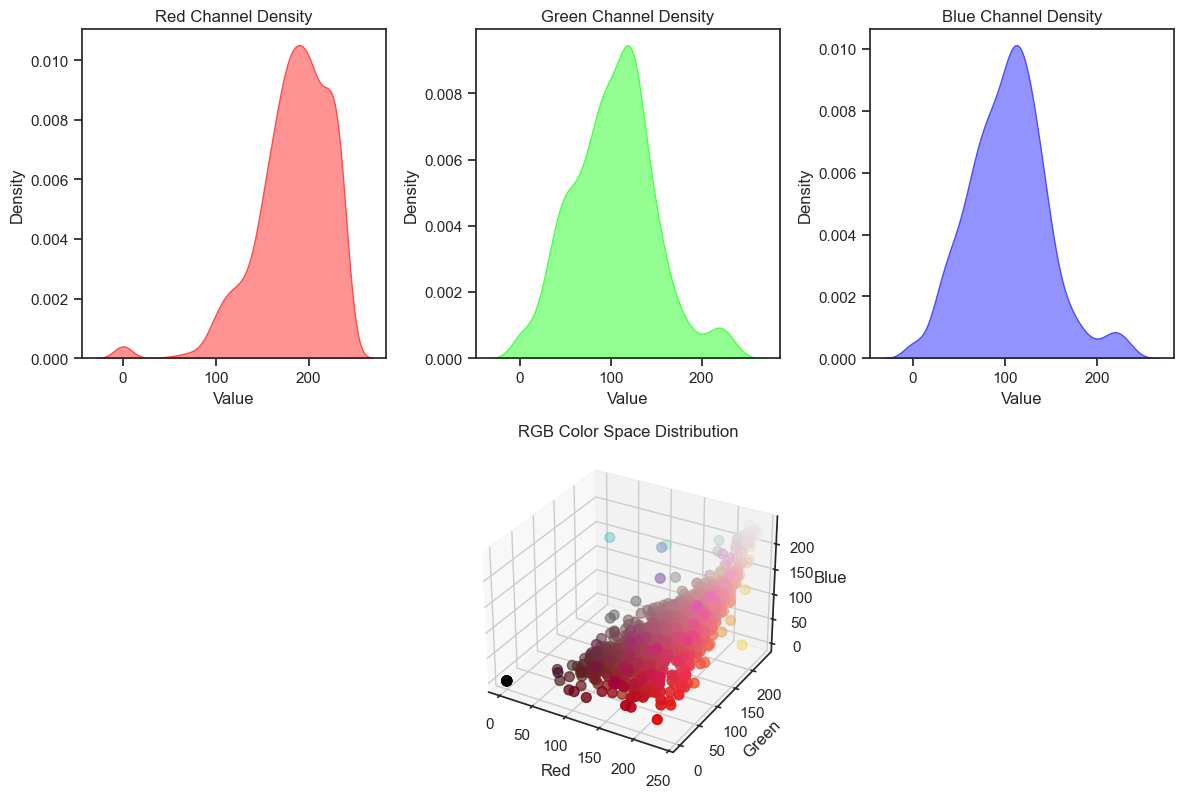

In [14]:


def visualize_color_metrics(df):
    """Advanced visualization of chromatic distributions"""
    rgb_matrix = np.stack(df['avg_rgb'].dropna().values)
    
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    
    # RGB Channels Distribution
    channels = ['Red', 'Green', 'Blue']
    colors = ['#FF4B4B', '#4BFF4B', '#4B4BFF']
    
    for idx, (channel, color) in enumerate(zip(channels, colors)):
        ax = fig.add_subplot(gs[0, idx])
        
        # Using KDE plot for smooth distribution
        sns.kdeplot(
            data=rgb_matrix[:, idx],
            fill=True,
            color=color,
            alpha=0.6,
            ax=ax
        )
        ax.set_title(f'{channel} Channel Density')
        ax.set_xlabel('Value')
        
    # 3D RGB Space Visualization
    ax_3d = fig.add_subplot(gs[1, :], projection='3d')
    scatter = ax_3d.scatter(
        rgb_matrix[:, 0],
        rgb_matrix[:, 1],
        rgb_matrix[:, 2],
        c=rgb_matrix/255,
        s=50
    )
    ax_3d.set_title('RGB Color Space Distribution')
    ax_3d.set_xlabel('Red')
    ax_3d.set_ylabel('Green')
    ax_3d.set_zlabel('Blue')
    
    plt.tight_layout()
    plt.show()

# Plot color distributions
visualize_color_metrics(df_products_with_images)

In [11]:
df_products_with_images.columns

Index(['productID', 'skuID', 'Name', 'Brand', 'BrandExternalId', 'CategoryId',
       'TotalReviewCount', 'ReviewStatistics', 'AverageOverallRating',
       'FirstSubmissionTime', 'RecommendedCount', 'NotRecommendedCount',
       'RatingDistribution', 'ContextDataDistribution.age.Values',
       'ContextDataDistribution.skinType.Values',
       'ContextDataDistribution.skinConcerns.Values',
       'ContextDataDistribution.skinTone.Values',
       'ContextDataDistribution.eyeColor.Values',
       'ContextDataDistribution.hairColor.Values', 'cover_image_base64',
       'lipstick_image_base64', 'avg_rgb'],
      dtype='object')

Found 200 products with valid images


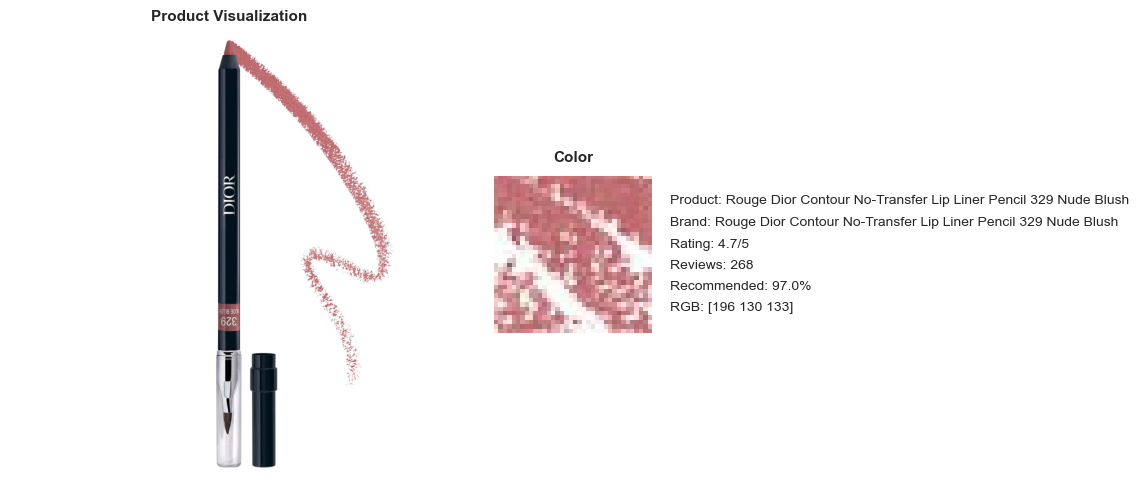

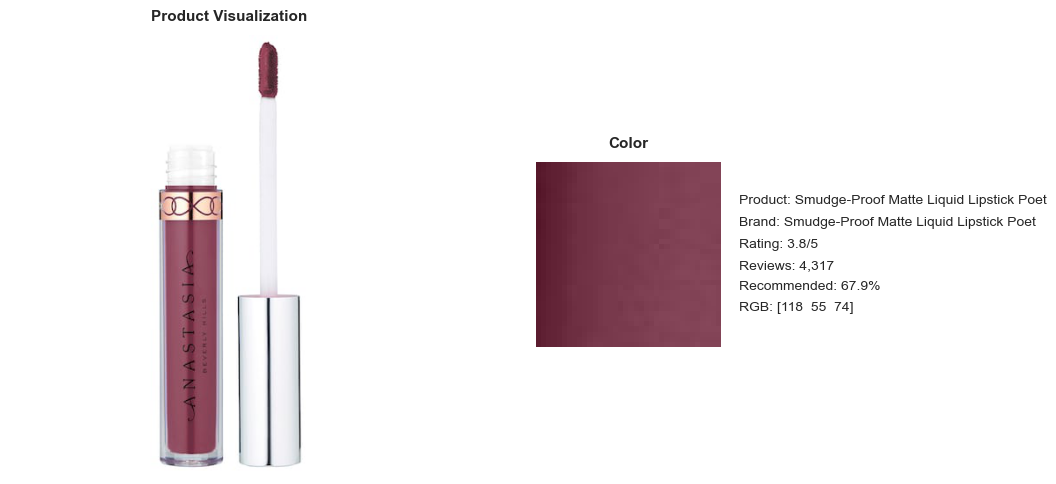

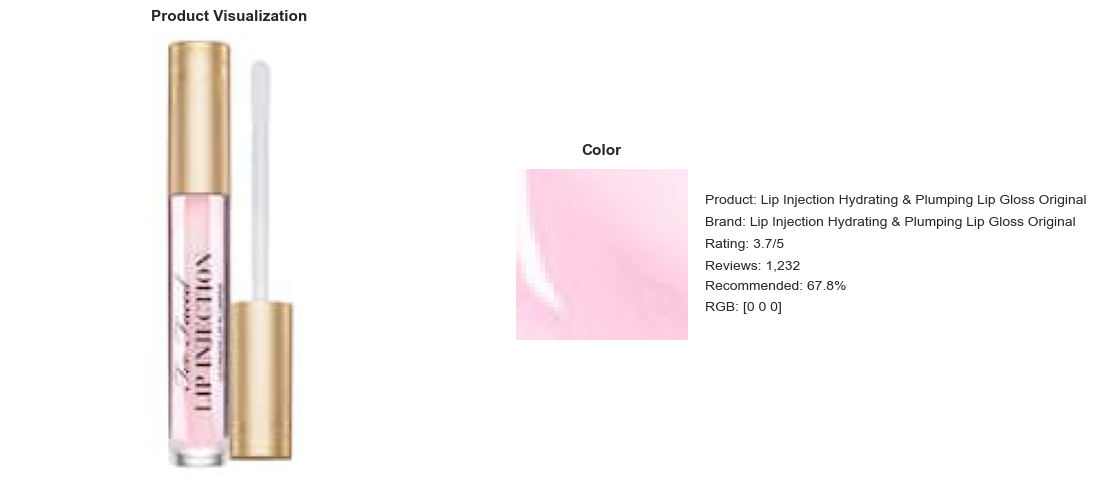

In [15]:
def showcase_product_analysis(df, sku_identifier):

    try:
        product_data = df[df['skuID'] == sku_identifier].iloc[0]

        if not pd.notna(product_data['cover_image_base64']) or \
           not is_valid_base64_image(product_data['cover_image_base64']):
            return False

        fig = plt.figure(figsize=(12, 5))
        gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 0.8, 1.2])

        ax_main = fig.add_subplot(gs[0])
        img_main = Image.open(BytesIO(base64.b64decode(product_data['cover_image_base64'])))
        ax_main.imshow(img_main)
        ax_main.set_title('Product Visualization', pad=10, fontsize=11, fontweight='bold')
        ax_main.axis('off')

        ax_color = fig.add_subplot(gs[1])
        if pd.notna(product_data['lipstick_image_base64']) and \
           is_valid_base64_image(product_data['lipstick_image_base64']):
            img_color = Image.open(BytesIO(base64.b64decode(product_data['lipstick_image_base64'])))
            ax_color.imshow(img_color)
        ax_color.set_title('Color', pad=10, fontsize=11, fontweight='bold')
        ax_color.axis('off')

        metadata_text = (
            f"Product: {product_data['Name']}\n"
            f"Brand: {product_data['Name'].split(' - ')[0]}\n"
            # f"SKU: {sku_identifier}\n"
            f"Rating: {product_data['AverageOverallRating']:.1f}/5\n"
            f"Reviews: {product_data['TotalReviewCount']:,}\n"
            f"Recommended: {(product_data['RecommendedCount'] / (product_data['RecommendedCount'] + product_data['NotRecommendedCount']) * 100):.1f}%\n"
            f"RGB: {product_data['avg_rgb']}"
        )

        ax_info = fig.add_subplot(gs[2])
        ax_info.text(0, 0.5, metadata_text,
                    fontsize=10,
                    va='center',
                    ma='left',
                    linespacing=2,
                    transform=ax_info.transAxes)
        ax_info.axis('off')

        plt.tight_layout()
        plt.show()
        return True

    except Exception as e:
        print(f"Error processing product {sku_identifier}: {e}")
        return False

def analyze_sample_products(df, n_samples=3):

    valid_products = df[
        df['cover_image_base64'].notna() & 
        df['lipstick_image_base64'].notna()
    ].copy()

    valid_products['valid_cover'] = valid_products['cover_image_base64'].apply(is_valid_base64_image)
    valid_products['valid_lipstick'] = valid_products['lipstick_image_base64'].apply(is_valid_base64_image)

    complete_data = valid_products[
        valid_products['valid_cover'] & 
        valid_products['valid_lipstick']
    ]

    if len(complete_data) == 0:
        print("No products found with valid image data.")
        return

    print(f"Found {len(complete_data)} products with valid images")

    shown_products = 0
    shuffled_skus = complete_data['skuID'].sample(frac=1).tolist()

    for sku in shuffled_skus:
        if shown_products >= n_samples:
            break

        if showcase_product_analysis(df, sku):
            shown_products += 1
            print("\n")

def is_valid_base64_image(base64_str):

    try:
        if not isinstance(base64_str, str):
            return False

        img_data = base64.b64decode(base64_str)
        Image.open(BytesIO(img_data))
        return True
    except Exception:
        return False

analyze_sample_products(df_products_with_images, n_samples=3)

In [16]:
df_final.columns

Index(['reviewID', 'Rating', 'Title', 'ReviewText', 'Helpfulness',
       'IsRecommended', 'SubmissionTime',
       'ContextDataValues.skinType.ValueLabel',
       'ContextDataValues.eyeColor.ValueLabel',
       'ContextDataValues.hairColor.ValueLabel',
       'ContextDataValues.skinTone.ValueLabel',
       'ContextDataValues.age.ValueLabel',
       'ContextDataDistribution.skinConcerns.ValueLabel', 'productID', 'skuID',
       'Name', 'Brand', 'BrandExternalId', 'CategoryId', 'TotalReviewCount',
       'ReviewStatistics', 'AverageOverallRating', 'FirstSubmissionTime',
       'RecommendedCount', 'NotRecommendedCount', 'RatingDistribution',
       'ContextDataDistribution.age.Values',
       'ContextDataDistribution.skinType.Values',
       'ContextDataDistribution.skinConcerns.Values',
       'ContextDataDistribution.skinTone.Values',
       'ContextDataDistribution.eyeColor.Values',
       'ContextDataDistribution.hairColor.Values', 'cover_image_base64',
       'lipstick_image_base64'

## 7. Review Analysis

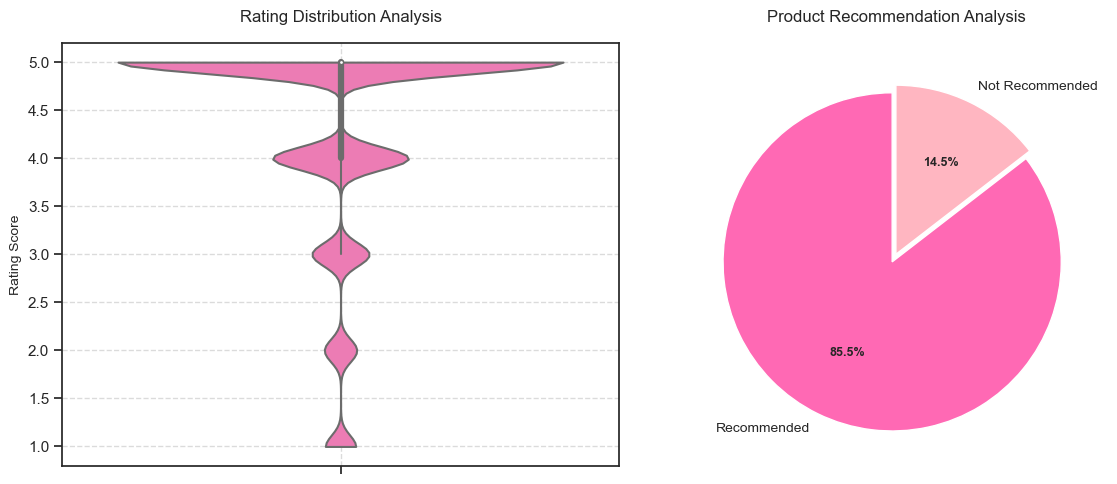

In [26]:
def analyze_basic_metrics(df):

    # Create main figure with GridSpec layout
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(1, 2)

    # 1. Rating Distribution Visualization
    ax1 = fig.add_subplot(gs[0])
    sns.violinplot(
        data=df,
        y='Rating',
        ax=ax1,
        inner='box',
        color='#FF69B4',
        cut=0
    )
    ax1.set_title('Rating Distribution Analysis', fontsize=12, pad=15)
    ax1.set_ylabel('Rating Score', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # 2. Product Recommendation Analysis
    ax2 = fig.add_subplot(gs[1])
    recommendation_data = df['IsRecommended'].value_counts(normalize=True) * 100
    colors = ['#FF69B4', '#FFB6C1']
    wedges, texts, autotexts = ax2.pie(
        recommendation_data,
        labels=['Recommended', 'Not Recommended'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        explode=(0.05, 0)
    )
    ax2.set_title('Product Recommendation Analysis', fontsize=12, pad=15)
    plt.setp(autotexts, size=9, weight="bold")
    plt.setp(texts, size=10)

    plt.tight_layout()
    plt.show()


analyze_basic_metrics(df_final)

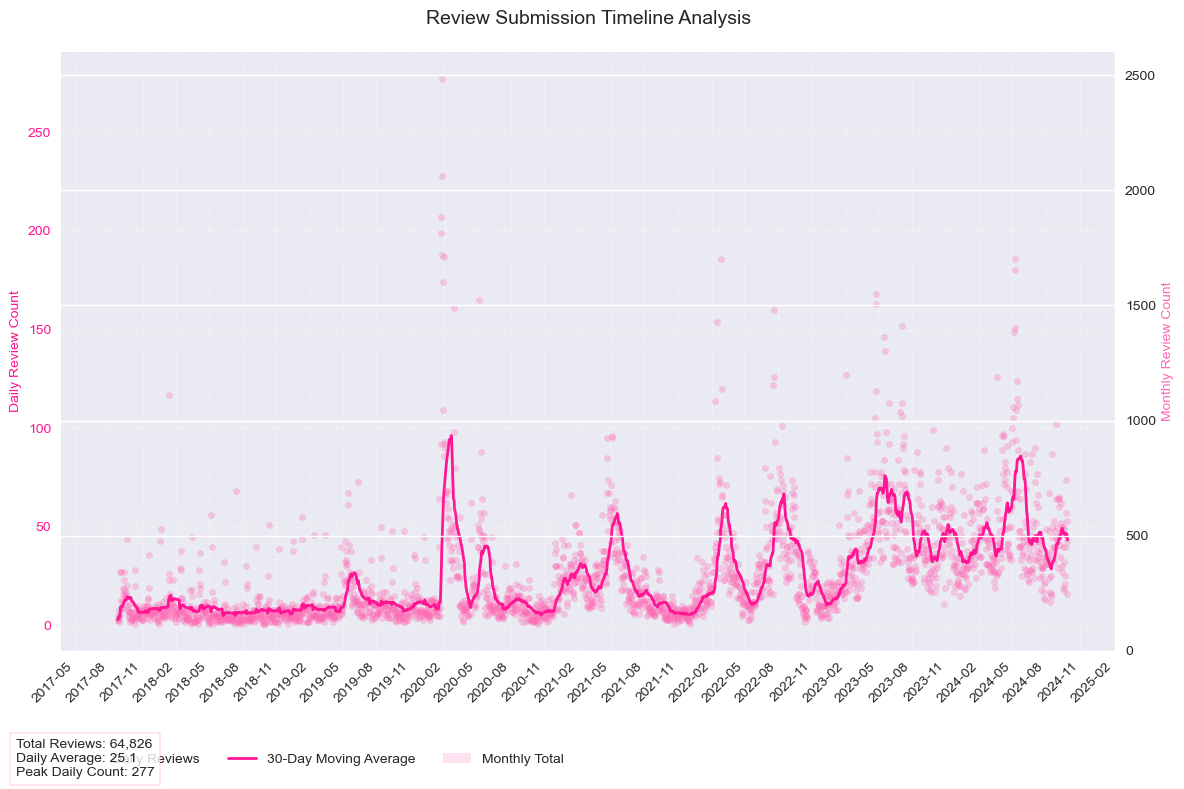

In [33]:
def analyze_timeline(df):

    # Convert submission times to datetime
    df['SubmissionDate'] = pd.to_datetime(df['SubmissionTime'])

    # Create daily aggregation
    daily_data = (df.groupby(df['SubmissionDate'].dt.strftime('%Y-%m-%d'))
                    .size()
                    .reset_index())
    daily_data.columns = ['date', 'count']
    daily_data['date'] = pd.to_datetime(daily_data['date'])

    # Calculate rolling average (30-day window)
    rolling_avg = daily_data.set_index('date')['count'].rolling(window=30, min_periods=1).mean()

    # Create monthly aggregation
    monthly_data = (df.groupby(df['SubmissionDate'].dt.strftime('%Y-%m'))
                    .size()
                    .reset_index())
    monthly_data.columns = ['date', 'count']
    monthly_data['date'] = pd.to_datetime(monthly_data['date'])

    # Create visualization
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Set style
    plt.style.use('seaborn')

    # Plot daily scatter points
    ax1.scatter(
        daily_data['date'].values,
        daily_data['count'].values,
        alpha=0.3,
        s=20,
        color='#FF69B4',
        label='Daily Reviews'
    )

    # Plot rolling average
    ax1.plot(
        rolling_avg.index.values,
        rolling_avg.values,
        color='#FF1493',
        linewidth=2,
        label='30-Day Moving Average',
        zorder=3
    )

    # Configure primary axis
    ax1.set_ylabel('Daily Review Count', fontsize=10, color='#FF1493')
    ax1.tick_params(axis='y', labelcolor='#FF1493')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Add monthly totals as bars on secondary axis
    ax2 = ax1.twinx()
    ax2.bar(
        monthly_data['date'].values,
        monthly_data['count'].values,
        alpha=0.2,
        color='#FF69B4',
        width=20,
        label='Monthly Total'
    )
    ax2.set_ylabel('Monthly Review Count', fontsize=10, color='#FF69B4')

    # Configure x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Set title and style
    plt.title('Review Submission Timeline Analysis', pad=20, fontsize=14)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines2,
        labels1 + labels2,
        loc='upper left',
        bbox_to_anchor=(0, -0.15),
        ncol=3
    )

    # Rotate x-axis labels
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Add statistics
    stats_text = (
        f"Total Reviews: {len(df):,}\n"
        f"Daily Average: {daily_data['count'].mean():.1f}\n"
        f"Peak Daily Count: {daily_data['count'].max():,}"
    )

    plt.figtext(
        0.02, 0.02, stats_text,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='#FF69B4')
    )

    plt.tight_layout()
    plt.show()


analyze_timeline(df_final)